## 2D Heat Diffusion -- Explicit

In [2]:
import numpy as np
import sympy as sp
from matplotlib import pyplot
%matplotlib inline

In [16]:
# Utilize central difference scheme to solve the 2D heat diffusion equation
# dT / dt = a (d2T/dx2 + d2T/dy2)
# Stability condition for both directions (x, y) sigma_x + sigma_y <= 0.5

# sigma_x = alpha * (dt / dx**2) 
# sigma_y = alpha * (dt / dy**2)
# if dx = dy = delta, then alpha * (dt / delta**2) <= 0.25

In [17]:
L = 0.01
nx, ny = 21, 21
dx = L / (nx - 1)
dy = L / (ny - 1)
x = np.linspace(0.0, L, num=nx)
y = np.linspace(0.0, L, num=ny)

alpha = 1e-4          #thermal diffusivity

# Initial Conditions
T0 = np.full([ny,nx], 20.0)             # matrix with ny rows and nx columns
# modify 2d array to include derichlet values and bottom boundaries
T0[0, :] = 100 #bottom boundary; 0 indicates row and colon indicates all values along
T0[:, 0] = 100.0 # left boundary

In [25]:
def ftcs(T0, nt, dt, dx, dy, alpha, qx=0., qy =0.):
    sigma_x = alpha * (dt / dx**2)
    sigma_y = alpha * (dt / dy**2)
    
    T = T0.copy()
    
    ny,nx = T.shape
    I, J = nx // 2, ny //2 #double division forces an integer type to be returned
    
    for n in range(nt):
        T[1:-1, 1:-1] = (T[1:-1, 1:-1] + 
                         sigma_x * (T[1:-1, :-2] - 2 * T[1:-1, 1:-1] + T[1:-1, 2:]) + 
                        sigma_y * (T[:-2, 1:-1] - 2 * T[1:-1, 1:-1] + T[2: , 1:-1]))
        # Update Boundary Values (Neumann Condition)
        T[:, -1] = T[:, -2] + qx*dx  # right boundary
        T[-1, :] = T[-2, :] + qy*dy  # bottom boundary
        if T[J, I] >= 70.:           # temp at center of domain limit = 70 deg C
            break
        
    print(n+1, T[J, I])              # prints the time step and what the temperature is at the center of the domain
        
    return T

In [61]:
nt = 500
sigma = 0.25
dt = sigma * min(dx,dy)**2 / alpha

T = ftcs(T0, nt, dt, dx, dy, alpha, qx=0, qy=0)

256 70.02138294076626


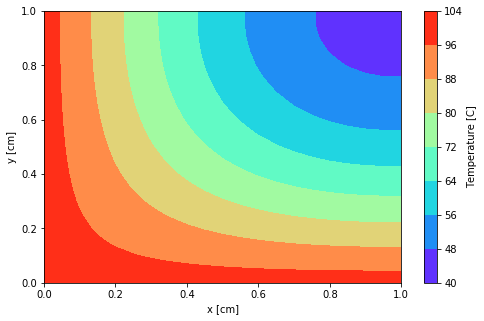

In [62]:
pyplot.figure(figsize=(8. , 5.))
pyplot.xlabel('x [cm]')
pyplot.ylabel('y [cm]')
contf = pyplot.contourf(x*100, y*100, T, cmap='rainbow');
cbar = pyplot.colorbar(contf)
cbar.set_label('Temperature [C]')

## 2D Diffusion -- Implicit

In [65]:
def btcs(T0, nt, dt, delta, alpha):
    sigma = alpha * dt / delta**2
    # Crate LHS Op
    A = lhs_op()
    T = map_2d_to_1d(T0)
    # integrate in time
    for n in range(nt):
        b = rhs_vector()
        T = np.linalg.solve(A, b)
    return map_1d_to_2d(T)

In [64]:
def lhs_op(M, N, sigma):
    A = np.zeros((M * N, M * N))
    for j in range(N):
        for i in range(M):
            I = J*M + i  # defines row index
            
            south = I - M
            west = I - 1
            east = I + 1
            north = I + M
            
            # Setup corner points
            if i == 0 and j == 0: #bottom-left corner
                A[I,I] = 1. / sigma + 4.0
                A[I,east] = -1.
                A[I, north] = -1.
            elif i == M - 1 and j == 0:
                A[I,I] = 1.0 / sigma + 3.
                A[I, west] = -1.
                A[I, north] = -1.
            elif i == 0 and j == N-1: #top-left corner
                A[I,I] = 1. / sigma + 3.0
                A[I, south] = -1.0
                A[I, east] = -1.0
            elif i == M - 1 and j == N-1: #top-right corner
                A[I,I] = 1.0 / sigma + 2.0
                A[I, south] = -1.0
                A[I, west] = -1.0
            # Setup side points except corners
            elif i == 0: #left-side
                A[I,I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M-1: #right  side
                A[I,I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif j == 0: #bottom side
                A[I,I] = 1.0 / sigma + 4.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north]= -1.0
            elif j == n-1: #top side
                A[I,I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
            # Setup interior points
            else:
                A[I,I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, north]= -1.0
                A[I, east] = -1.0
    return A  

In [66]:
def rhs_vector(T, M, N, sigma, Tb):
    b = 1.0 / sigma * T
    # Add derichlet term at pts located next to left and bottom boundaries
    for j in range(N):
        for i in range(M):
            I = j * M + i
            if i == 0:
                b[I] += Tb
            if j == 0:
                b[I] += Tb
    return b

In [67]:
def map_1d_to_2d(T_1d, nx, ny, Tb):
    T=np.zeros((ny, nx))
    # Get value of interior points
    T[1:-1, 1:-1] = T_1d.reshape((ny - 2, nx - 2))
    # use Derichlet BC at left and bottom
    T[:, 0] = Tb
    T[0, :] = Tb
    # use Neumann BC at right and top
    T[:, -1] = T[:, -2]
    T[-1, :] = T[-2, :]
    return T

In [68]:
# To advance in time, use this cell
def btcs_implicit_2d(T0, nt, dt, dx, alpha, Tb):
    ny, nx = T0.shape
    M = nx - 2
    N = ny - 2
    sigma = alpha * dt/dx**2
    A = lhs_op(M, N, sigma)
    T = T0[1:-1, 1:-1].flatten()
    I, J = int(M / 2), int(N/2)
    for n in range(nt):
        b = rhs_vector(T, M, N, sigma, Tb)
        T = linalg.solve(a, b)
        if T[J* M + I] >= 70.0:
            break
    print('[time step{}] center at T={:.2f} at t={:.2f} s'.format(n+1, T[J*M+I], (n+1)*dt))
    return map_1d_to_2d(T, nx, ny, Tb)

In [ ]:
btcs_implicit